In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('SCMS_Delivery_History_Dataset_20150929.csv')

In [3]:
data

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,C�te d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,C�te d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/2014,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,C�te d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/2014,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/2014,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/2015,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

## Preprocessing

In [5]:
def preprocess_inputs(df, label_mapping):
    df = df.copy()
    
    # Drop ID column
    df = df.drop('ID', axis=1)
    
    # Drop missing target rows
    missing_target_rows = df[df['Shipment Mode'].isna()].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)
    
    # Fill missing values
    df['Dosage'] = df['Dosage'].fillna(df['Dosage'].mode()[0])
    df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].mean())
    
    # Drop date columns with too many missing values
    df = df.drop(['PQ First Sent to Client Date', 'PO Sent to Vendor Date'], axis=1)
    
    # Extract date features
    for column in ['Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']:
        df[column] = pd.to_datetime(df[column])
        df[column + ' Year'] = df[column].apply(lambda x: x.year)
        df[column + ' Month'] = df[column].apply(lambda x: x.month)
        df[column + ' Day'] = df[column].apply(lambda x: x.day)
        df = df.drop(column, axis=1)
    
    # Drop numeric columns with too many missing values
    df = df.drop(['Weight (Kilograms)', 'Freight Cost (USD)'], axis=1)
    
    # Drop high-cardinality columns
    df = df.drop(['PQ #', 'PO / SO #', 'ASN/DN #'], axis=1)
    
    # Binary encoding
    df['Fulfill Via'] = df['Fulfill Via'].replace({'Direct Drop': 0, 'From RDC': 1})
    df['First Line Designation'] = df['First Line Designation'].replace({'No': 0, 'Yes': 1})
    
    # One-hot encoding
    for column in df.select_dtypes('object').columns.drop('Shipment Mode'):
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    
    # Split df into X and y
    y = df['Shipment Mode']
    X = df.drop('Shipment Mode', axis=1)
    
    # Encode the labels
    y = y.replace(label_mapping)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [6]:
LABEL_MAPPING = {
    'Air': 0,
    'Truck': 1,
    'Air Charter': 2,
    'Ocean': 3
}

X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=LABEL_MAPPING)

In [7]:
X_train

Fulfill Via  Unit of Measure (Per Pack)  Line Item Quantity  \
8905     0.975074                   -0.228739           -0.426393   
1414     0.975074                   -0.228739            0.198248   
1409     0.975074                   -0.228739            0.532553   
874     -1.025563                    0.291362           -0.450154   
1941     0.975074                   -0.618816            0.159722   
...           ...                         ...                 ...   
2895    -1.025563                   -0.228739           -0.407975   
7813     0.975074                   -0.228739           -0.005566   
905     -1.025563                   -0.618816            1.611276   
5192    -1.025563                    0.291362           -0.281635   
235     -1.025563                   -0.228739           -0.455200   

      Line Item Value  Pack Price  Unit Price  First Line Designation  \
8905        -0.442833   -0.365576   -0.221030                0.673216   
1414         0.418854   -0.218907   -0.172736                0.673216   
1409         0.366882   -0.309884   -0.203468                0.673216   
874         -0.274234    2.493413    0.354098                0.673216   
1941         0.338381   -0.227409   -0.093711                0.673216   
...               ...         ...         ...                     ...   
2895        -0.436590   -0.377267   -0.225420               -1.485408   
7813        -0.331187   -0.409364   -0.238591                0.673216   
905          2.247912   -0.223796   -0.093711                0.673216   
5192         1.413370    1.430592    0.134584                0.673216   
235         -0.449668   -0.131330   -0.142004               -1.485408   

      Line Item Insurance (USD)  Scheduled Delivery Date Year  \
8905                  -0.471452                      1.087860   
1414                   0.702302                     -0.994006   
1409                   0.632237                     -0.994006   
874                   -0.278564                     -1.410379   
1941                   0.593803                     -0.994006   
...                         ...                           ...   
2895                  -0.467031                      1.087860   
7813                  -0.358993                      0.255114   
905                    2.497515                     -1.410379   
5192                   2.296044                     -0.577633   
235                   -0.468751                     -0.994006   

      Scheduled Delivery Date Month  Scheduled Delivery Date Day  \
8905                       0.760567                     1.293380   
1414                       0.456201                    -1.471641   
1409                      -0.152532                    -0.195478   
874                       -1.674365                     0.017216   
1941                      -0.456899                    -1.046253   
...                             ...                          ...   
2895                       1.064934                     0.229910   
7813                       0.760567                     1.080686   
905                        0.760567                     0.548951   
5192                       1.369300                    -0.620866   
235                       -1.065632                     1.293380   

      Delivered to Client Date Year  Delivered to Client Date Month  \
8905                       1.088220                        0.154064   
1414                      -0.985911                        0.454943   
1409                      -0.985911                       -0.146816   
874                       -1.400738                       -1.651214   
1941                      -0.985911                       -0.447695   
...                             ...                             ...   
2895                       1.088220                        1.056703   
7813                       0.258568                        1.056703   
905                       -1.400738                        0.75

In [8]:
y_train.value_counts()

0    4317
1    1950
2     449
3     258
Name: Shipment Mode, dtype: int64

## Training

In [9]:
X_train.shape

(6974, 771)

In [10]:
inputs = tf.keras.Input(shape=(771,))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
175/175 [==============================] - 1s 3ms/step - loss: 0.4511 - accuracy: 0.8277 - val_loss: 0.2996 - val_accuracy: 0.8767
Epoch 2/100
175/175 [==============================] - 0s 1ms/step - loss: 0.2321 - accuracy: 0.9011 - val_loss: 0.2956 - val_accuracy: 0.8817
Epoch 3/100
175/175 [==============================] - 0s 1ms/step - loss: 0.1946 - accuracy: 0.9175 - val_loss: 0.3028 - val_accuracy: 0.8853
Epoch 4/100
175/175 [==============================] - 0s 1ms/step - loss: 0.1773 - accuracy: 0.9217 - val_loss: 0.2787 - val_accuracy: 0.8968
Epoch 5/100
175/175 [==============================] - 0s 1ms/step - loss: 0.1598 - accuracy: 0.9351 - val_loss: 0.2976 - val_accuracy: 0.8789
Epoch 6/100
175/175 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9321 - val_loss: 0.3036 - val_accuracy: 0.8889
Epoch 7/100
175/175 [==============================] - 0s 1ms/step - loss: 0.1419 - accuracy: 0.9385 - val_loss: 0.2946 - val_accuracy: 0.8968

## Results

Test Set Accuracy: 87.19%


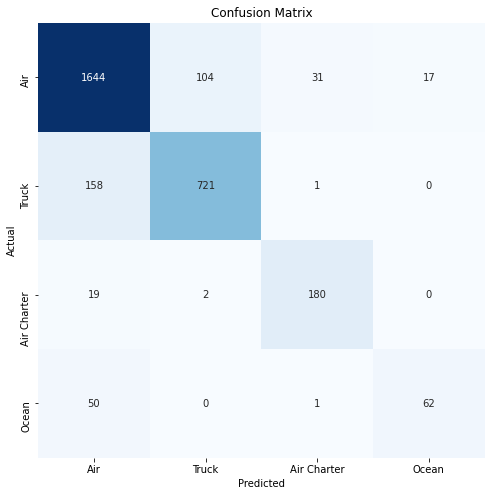

Classification Report:
----------------------
               precision    recall  f1-score   support

         Air       0.88      0.92      0.90      1796
       Truck       0.87      0.82      0.84       880
 Air Charter       0.85      0.90      0.87       201
       Ocean       0.78      0.55      0.65       113

    accuracy                           0.87      2990
   macro avg       0.85      0.79      0.81      2990
weighted avg       0.87      0.87      0.87      2990



In [12]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(LABEL_MAPPING.values()))
clr = classification_report(y_test, y_pred, labels=list(LABEL_MAPPING.values()), target_names=list(LABEL_MAPPING.keys()))

print("Test Set Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)